If we are going to train a neural network to recognize sudoku puzzles, then we are going to need some training data. I have no interest in sifting through sudoku puzzle books taking pictures of the puzzles, and then manually recording the correct interpretation of the puzzle. So what's the alternative? Well what if we create a random "puzzle", and then construct the image from that? It's hard to say if this approach will generalize to real pictures of sudokus, but if it does it will be a much more efficient way to train the network. For that reason I think it's worth trying.

If we are going to generate images of sudoku puzzles then first we will need the sudoku grid:

In [1]:
import os
import numpy as np
from scipy import ndimage
import imageio
import random
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import pylab
import datetime

import keras
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks

OUTPUT_DIR = 'sudoku_ocr'

thick_line_width = 3
thin_line_width = 1
cell_width = 28

thick_lines = [i * thick_line_width + 
               2 * i * thin_line_width + 
               3 * i * cell_width
               for i in range(4)
              ]

thin_lines =  [((i // 2) + 1) * thick_line_width + 
               i * thin_line_width + 
               (i + 1 + i // 2) * cell_width
               for i in range(6)
              ]

digits = [int(i + thick_line_width) for i in thick_lines[:-1]]
digits += [int(i + thin_line_width) for i in thin_lines]
digits = sorted(digits)

# A function that creates a 9x9 sudoku board in numpy
def generate_sudoku_grid():
    size = 9 * cell_width + 4 * thick_line_width + 6 * thin_line_width
    sudoku_grid = np.ones((size, size))

    for line in thick_lines:
        sudoku_grid[line:line + thick_line_width, :] = 0.
        sudoku_grid[:, line:line + thick_line_width] = 0.

    for line in thin_lines:
        sudoku_grid[line:line + thin_line_width, :] = 0.
        sudoku_grid[:, line:line + thin_line_width] = 0.
    
    return sudoku_grid

plt.imshow(generate_sudoku_grid(), cmap = 'gray')
plt.show()

/home/everett/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Now that we have a grid, we will need to populate it with some digits. I have some nice hand drawn digits from my MNIST adversarial examples post that might be useful for this. Of course most sudokus in their virgin state don't have any hand writing on them, so we will also want some printed digits too. Luckily there are a number of free and open fonts available which allowed for a variety of stroke widths and serif/non-serif options. I also want the model to account for a variety of sizes for the digits in the cells:

In [2]:
# Load the new hand drawn digits from file
handwritten_digits = []

for i in range(10):
    im = imageio.imread('fonts/handwritten_digits/{}.png'.format(i))
    handwritten_digits.append(im[:, :, 0] / 255.)
    
# Get a list of fonts for rendering digits
fonts = os.listdir('fonts/')

# Create an array of viable font sizes
font_sizes = list(range(24,32,2))

In [3]:
# Render an individual digit using one of the above fonts
def render_digit_font(digit, font='Roboto-Medium.ttf', size=28):
    # create Image object with the input image
    imgx = cell_width # image width in pixels
    imgy = cell_width # image height in pixels
    digit_image = Image.new("L", (imgx, imgy), color='white')

    # initialise the drawing context with
    # the image object as background
    draw = ImageDraw.Draw(digit_image)

    # desired size
    font = ImageFont.truetype('fonts/'+font, size)

    unicode_digit = str(digit)
    text_width, text_height = font.getsize(unicode_digit)    
    fontx = (cell_width / 2) - (text_width / 2)
    fonty = (cell_width / 2) - (4/3 * text_height / 2)

    # starting position of the message
    (x, y) = (fontx, fonty)
    color = 'black'

    # draw the message on the background
    draw.text((x, y), unicode_digit, fill=color, font=font)

    return np.array(digit_image) / 255.

# Get a digit in the specified font including handwritten
def render_digit(digit, font="handwritten_digits", size=28):
    if font == "handwritten_digits":
        return handwritten_digits[int(digit)]
    
    return render_digit_font(digit, font, size)
        

# Populate a sudoku_grid with digits
def render_sudoku(sudoku, font="handwritten_digits", digit_size=28):
    sudoku_grid = generate_sudoku_grid()
    
    for i, x in enumerate(digits):
        for j, y in enumerate(digits):
            if sudoku[i,j] > 0:
                digit = render_digit(sudoku[i,j], font, digit_size)
                sudoku_grid[x:x+cell_width, y:y+cell_width] = digit
    
    return speckle(sudoku_grid)

# this creates larger "blotches" of noise which look
# more realistic than just adding gaussian noise
# assumes greyscale with pixels ranging from 0 to 1

def speckle(img):
    severity = np.random.uniform(0, 0.6)
    blur = ndimage.gaussian_filter(np.random.randn(*img.shape) * severity, 1)
    img_speck = (img + blur)
    img_speck[img_speck > 1] = 1
    img_speck[img_speck <= 0] = 0
    return img_speck

With the code to render arbitrary sudoku puzzles complete, we will need a way to generate puzzles to render. I'm ot actually worried about whether or not my puzzles are real sudokus that adhere to the rules, because the intent is only to train the capsule network to reognize the digits in the correct cells of the sudoku grid, not to solve the puzzle. With this in mind I will generate a 9x9 grid with random digits between 0 and 9, where 0 is treated as a blank cell:

In [4]:
# Create a mock sudoku with randomly assigned digits
def generate_mock_sudoku():
    mock_sudoku = np.zeros((9,9), dtype=int)
    rows = mock_sudoku.shape[0]
    cols = mock_sudoku.shape[1]
    
    for row in range(rows):
        for col in range(cols):
            mock_sudoku[row,col] = random.randint(0,9)
            
    return mock_sudoku  

# Convert a sudoku puzzle to the form d,d,d,d,d,d,d,...,d
# which is the format needed for my sudoku solver android app.
def sudoku_to_string(sudoku):
    return ','.join(sudoku.reshape((81)).astype('str'))

Let's see if this sudoku generating process has worked:

Courier Prime Bold.ttf


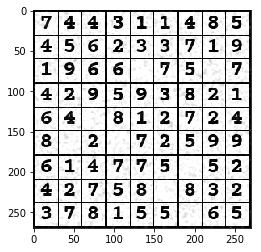

Vollkorn-Semibold.ttf


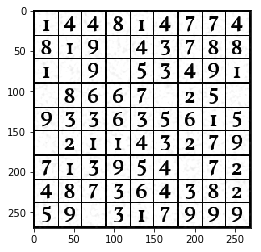

FeENrm28C.otf


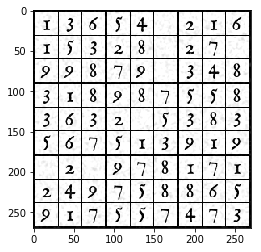

Roboto-Bold.ttf


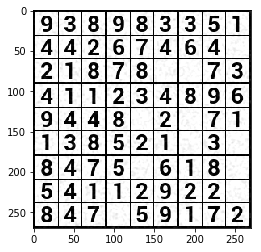

OpenSans-Bold.ttf


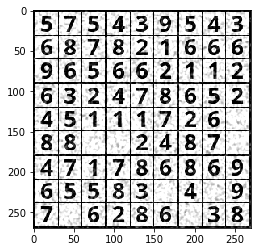

OpenSans-ExtraBold.ttf


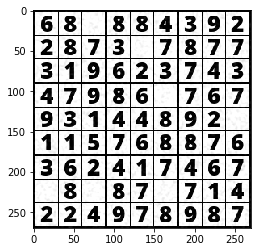

Courier Prime.ttf


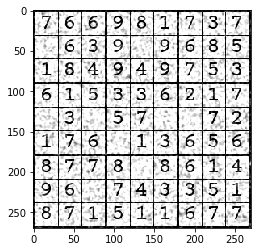

Roboto-Medium.ttf


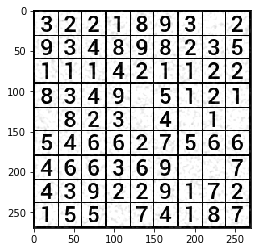

Vollkorn-Regular.ttf


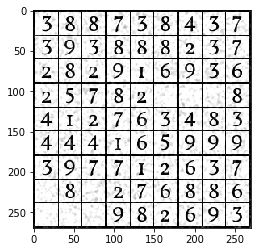

OpenSans-Regular.ttf


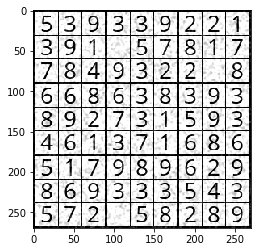

Roboto-Regular.ttf


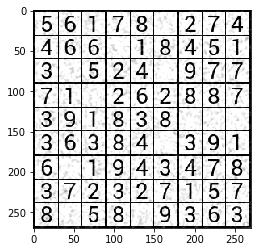

handwritten_digits


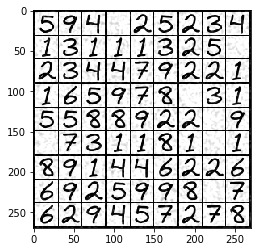

OpenSans-Semibold.ttf


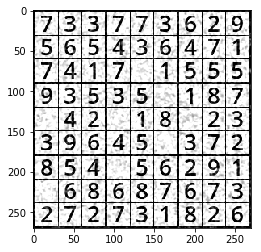

Vollkorn-Bold.ttf


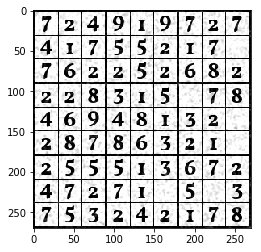

OpenSans-Light.ttf


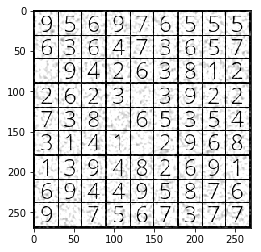

Roboto-Light.ttf


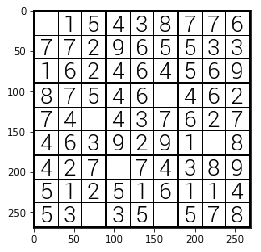

In [5]:
SEED = 27
random.seed(SEED)

for font in fonts:
    print(font)
    image = render_sudoku(generate_mock_sudoku(), font, 28)
    
    plt.imshow(image, cmap='gray')
    plt.show()

In [6]:
%timeit render_sudoku(generate_mock_sudoku(), random.choice(fonts), random.choice(font_sizes))

34 ms ± 3.49 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


The rendering of sudokus works pretty well, but it's not the fastest process. We are able to generate approximately 30 of them per second. It is possible that this will be fast enough for a capsule network in Keras, but I'm not really sure. In the meantime I think it will make sense to pregenerate the training, validation, and test data sets using the above functions. Capsule networks are supposed to be more efficient in learning, so I will start with 20 mock sudokus for each font and font_size combination for a total of 12,80 training examples. For validation and test sets I will generate an additional 50 examples for each font and font_size:

In [7]:
def shuffle_mats_or_lists(matrix_list, stop_ind=None):
    ret = []
    assert all([len(i) == len(matrix_list[0]) for i in matrix_list])
    len_val = len(matrix_list[0])
    if stop_ind is None:
        stop_ind = len_val
    assert stop_ind <= len_val

    a = list(range(stop_ind))
    np.random.shuffle(a)
    a += list(range(stop_ind, len_val))
    for mat in matrix_list:
        if isinstance(mat, np.ndarray):
            ret.append(mat[a])
        elif isinstance(mat, list):
            ret.append([mat[i] for i in a])
        else:
            raise TypeError('`shuffle_mats_or_lists` only supports '
                            'numpy.array and list objects.')
    return ret

# Uses generator functions to supply train/test with
# data. Image renderings are sudoku puzzles created 
# on the fly each time with random perturbations

class SudokuImageGenerator(keras.callbacks.Callback):

    def __init__(self, minibatch_size, img_w, img_h, 
                 downsample_factor, val_split):

        self.minibatch_size = minibatch_size
        self.img_w = img_w
        self.img_h = img_h
        self.downsample_factor = downsample_factor
        self.val_split = val_split
        self.blank_label = self.get_output_size() - 1

    def get_output_size(self):
        return 11

    def build_sudoku_list(self, num_sudokus):
        assert num_sudokus % self.minibatch_size == 0
        assert (self.val_split * num_sudokus) % self.minibatch_size == 0
        self.num_sudokus = num_sudokus
        self.X_sudoku = np.ones([self.num_sudokus, 9, 9]) * -1
        self.X_text = []
        self.Y_data = np.ones([self.num_sudokus, 81]) * -1
        self.Y_len = [0] * self.num_sudokus

        for i in range(num_sudokus):
            sudoku = generate_mock_sudoku()
            self.X_sudoku[i, :, :] = sudoku
            self.X_text.append(sudoku_to_string(sudoku))
            self.Y_data[i, :] = sudoku.reshape((81))
            self.Y_len[i] = 81
        self.Y_len = np.expand_dims(np.array(self.Y_len), 1)

        self.cur_val_index = self.val_split
        self.cur_train_index = 0

    # each time an image is requested from train/val/test, a new random
    # painting of the text is performed
    def get_batch(self, index, size, train):
        # width and height are backwards from typical Keras convention
        # because width is the time dimension when it gets fed into the RNN
        if K.image_data_format() == 'channels_first':
            X_data = np.ones([size, 1, self.img_w, self.img_h])
        else:
            X_data = np.ones([size, self.img_w, self.img_h, 1])

        labels = np.ones([size, 81])
        input_length = np.zeros([size, 1])
        label_length = np.zeros([size, 1])
        source_sudoku = []
        for i in range(size):
            if K.image_data_format() == 'channels_first':
                X_data[i, 0, 0:self.img_w, :] = self.paint_func(self.X_sudoku[index + i])
            else:
                X_data[i, 0:self.img_w, :, 0] = self.paint_func(self.X_sudoku[index + i])
            labels[i, :] = self.Y_data[index + i]
            input_length[i] = self.img_w // self.downsample_factor - 2
            label_length[i] = 1
            source_sudoku.append(self.X_text[index + i])
        inputs = {'input': X_data,
                  'labels': labels,
                  'input_length': input_length,
                  'label_length': label_length,
                  'source_sudoku': source_sudoku # used for visualization only
                  }
        outputs = {'ctc': np.zeros([size])}  # dummy data for dummy loss function
        return (inputs, outputs)

    def next_train(self):
        while 1:
            ret = self.get_batch(self.cur_train_index, self.minibatch_size, train=True)
            self.cur_train_index += self.minibatch_size
            if self.cur_train_index >= self.val_split:
                self.cur_train_index = self.cur_train_index % 32
                (self.Y_data) = shuffle_mats_or_lists(
                    [self.Y_data], self.val_split)
            yield ret

    def next_val(self):
        while 1:
            ret = self.get_batch(self.cur_val_index, self.minibatch_size, train=False)
            self.cur_val_index += self.minibatch_size
            if self.cur_val_index >= self.num_sudokus:
                self.cur_val_index = self.val_split + self.cur_val_index % 32
            yield ret

    def on_train_begin(self, logs={}):
        self.build_sudoku_list(16000)
        self.paint_func = lambda sudoku: render_sudoku(sudoku, 
                                                       np.random.choice(fonts), 
                                                       np.random.choice(font_sizes))

    def on_epoch_begin(self, epoch, logs={}):
        self.paint_func = lambda sudoku: render_sudoku(sudoku, 
                                                       np.random.choice(fonts), 
                                                       np.random.choice(font_sizes))


In [8]:
# the actual loss calc occurs here despite it not being
# an internal Keras loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


# For a real OCR application, this should be beam search with a dictionary
# and language model.  For this example, best path is sufficient.
def decode_batch(test_func, word_batch):
    out = test_func([word_batch])[0]
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = str(out_best)
        ret.append(outstr)
    return ret


class VizCallback(keras.callbacks.Callback):

    def __init__(self, run_name, test_func, text_img_gen, num_display_words=6):
        self.test_func = test_func
        self.output_dir = os.path.join(
            OUTPUT_DIR, run_name)
        self.text_img_gen = text_img_gen
        self.num_display_words = num_display_words
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def on_epoch_end(self, epoch, logs={}):
        self.model.save_weights(os.path.join(self.output_dir, 'weights%02d.h5' % (epoch)))
        word_batch = next(self.text_img_gen)[0]
        res = decode_batch(self.test_func, word_batch['input'][0:self.num_display_words])
        cols = 1
        for i in range(self.num_display_words):
            pylab.subplot(self.num_display_words // cols, cols, i + 1)
            if K.image_data_format() == 'channels_first':
                the_input = word_batch['input'][i, 0, :, :]
            else:
                the_input = word_batch['input'][i, :, :, 0]
            pylab.imshow(the_input.T, cmap='Greys_r')
            pylab.xlabel('Truth = \'%s\'\nDecoded = \'%s\'' % (word_batch['source_sudoku'][i], res[i]))
        fig = pylab.gcf()
        fig.set_size_inches(10, 13)
        pylab.savefig(os.path.join(self.output_dir, 'e%02d.png' % (epoch)))
        pylab.close()

In [9]:
def train(run_name, start_epoch, stop_epoch):
    num_classes = 10
    epochs = 10

    words_per_epoch = 16000
    val_split = 0.2
    val_words = int(words_per_epoch * (val_split))

    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 512
    minibatch_size = 32

    # input image dimensions
    sudoku_size = 9 * cell_width + 4 * thick_line_width + 6 * thin_line_width
    img_h, img_w = sudoku_size, sudoku_size

    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)

    img_gen = SudokuImageGenerator(minibatch_size=minibatch_size,
                                   img_w=img_w,
                                   img_h=img_h,
                                   downsample_factor=(pool_size ** 2),
                                   val_split=words_per_epoch - val_words)

    input_layer = Input(shape=input_shape, name='input')
    inner = Conv2D(conv_filters, kernel_size=kernel_size,
                   padding='same', activation='relu',
                   name='conv1')(input_layer) 
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size=kernel_size,
                   padding='same', activation='relu',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation='relu', name='dense1')(inner)

    # Two layers of bidirectional GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(img_gen.get_output_size(), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    Model(inputs=input_layer, outputs=y_pred).summary()

    labels = Input(name='labels', shape=[81], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

    model = Model(inputs=[input_layer, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    
    # captures output of softmax so we can decode the output during visualization
    test_func = K.function([input_layer], [y_pred])

    viz_cb = VizCallback(run_name, test_func, img_gen.next_val())

    model.fit_generator(generator=img_gen.next_train(),
                        steps_per_epoch=(words_per_epoch - val_words) // minibatch_size,
                        epochs=stop_epoch,
                        validation_data=img_gen.next_val(),
                        validation_steps=val_words // minibatch_size,
                        callbacks=[viz_cb, img_gen]) #, 
                        #initial_epoch=start_epoch)

In [10]:
if __name__ == '__main__':
    run_name = datetime.datetime.now().strftime('%Y:%m:%d:%H:%M:%S')
    train(run_name, 0, 20)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 270, 270, 1)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 270, 270, 16) 160         input[0][0]                      
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 135, 135, 16) 0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 135, 135, 16) 2320        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/everett/.local/lib/python3.6/site-packages/keras/engine/training.py", line 2177, in fit_generator
    class_weight=class_weight)
  File "/home/everett/.local/lib/python3.6/site-packages/keras/engine/training.py", line 1849, in train_on_batch
    outputs = self.train_function(ins)
  File "/home/everett/.local/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2475, in __call__
    **self.session_kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 895, in run
    run_metadata_ptr)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1128, in _run
    feed_dict_tensor, options, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1344, in _do_run
    options, run_metadata)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py", line 1350, in _do_call
    return

TypeError: must be str, not list